In [58]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import seaborn as sns 
import missingno as msno 

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis 
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import lightgbm as lgb

import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report

from sklearn.inspection import permutation_importance

import imblearn
from imblearn.over_sampling import SMOTE


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_columns', None)

- We have 4 kinds of variable sets 
    - variable set 1: player attributes PC features
    - Variable set 2: betting information features
    - variable set 3: team attributes features
    - variable set 4: goal and win percentage rolling features
    - variable set 5: each team's Elo rating

In [4]:
df_match_basic = pd.read_csv("../data/df_match_basic.csv")

In [5]:
df_match_player_attr_pcs = pd.read_csv("../data/df_match_player_attr_pcs.csv")

In [6]:
df_match_betting_stat = pd.read_csv("../data/df_match_betting_stat.csv")

In [7]:
df_match_team_num_attr = pd.read_csv("../data/df_match_team_num_attr.csv")

In [8]:
df_team_win_goal_rolling_features = pd.read_csv("../data/df_team_win_goal_rolling_features.csv")

In [9]:
df_match_elo = pd.read_csv("../data/df_match_elo.csv")

- First, let's predict the match result and compare the result by using each variable sets.

# 1. Train test split

- Set last season as test set, other seasons as train set.

In [10]:
target_bool = (df_match_basic.match_api_id.isin(df_match_player_attr_pcs.match_api_id)) & \
              (df_match_basic.match_api_id.isin(df_match_betting_stat.match_api_id)) & \
              (df_match_basic.match_api_id.isin(df_match_team_num_attr.match_api_id)) & \
              (df_match_basic.match_api_id.isin(df_team_win_goal_rolling_features.match_api_id)) & \
              (df_match_basic.match_api_id.isin(df_match_elo.match_api_id))
    

In [11]:
target_matches = df_match_basic[target_bool]

In [12]:
test_match_api_id = target_matches[target_matches.season == "2015/2016"].match_api_id
train_match_api_id = target_matches[target_matches.season != "2015/2016"].match_api_id

In [13]:
print(len(train_match_api_id), len(test_match_api_id))

16988 2621


- There are 16,988 train set and 2,621 test set.

# 2. Baseline accuracy

In [14]:
df_match_basic[df_match_basic.match_api_id.isin(train_match_api_id)].match_result.value_counts()

home_win    7840
away_win    4855
draw        4293
Name: match_result, dtype: int64

<AxesSubplot:xlabel='match_result', ylabel='count'>

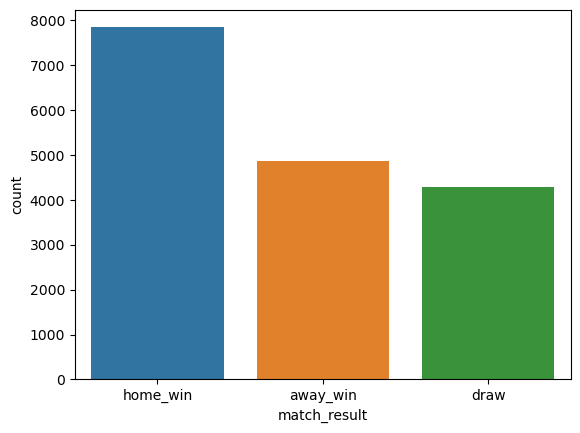

In [15]:
sns.countplot(x = df_match_basic[df_match_basic.match_api_id.isin(train_match_api_id)].match_result)

- About 46% of all 16,988 matches were won by the home team.
- That is, if we predict all matches as home team win, then we can achieve about 46% accuracy, that can be used as our baseline accuracy.

- Let's check the baseline accuracy in the test data set.

In [16]:
df_match_basic[df_match_basic.match_api_id.isin(test_match_api_id)].match_result.value_counts()

home_win    1161
away_win     801
draw         659
Name: match_result, dtype: int64

<AxesSubplot:xlabel='match_result', ylabel='count'>

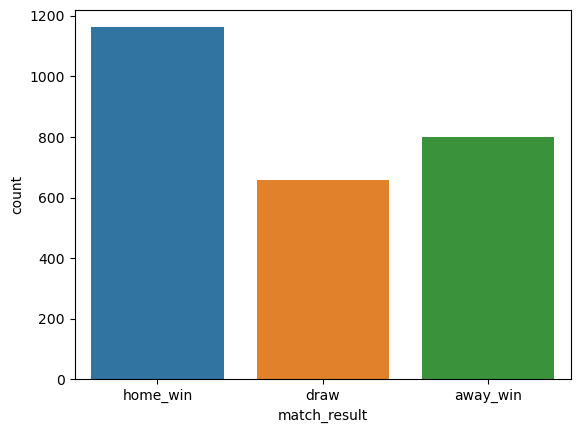

In [17]:
sns.countplot(x = df_match_basic[df_match_basic.match_api_id.isin(test_match_api_id)].match_result)

- Baseline accuracy in the test dataset is about 44% (1,161 / 2,621)

# 3. Modeling with all variable sets

## 3.1. Variable set 1: Player attributes PC features

In [18]:
df_match_player_attr_pcs = df_match_player_attr_pcs.merge(df_match_basic[["match_api_id", "match_result"]], how = "left", on = "match_api_id")

In [19]:
df_match_player_attr_pcs = df_match_player_attr_pcs.set_index("match_api_id")
df_match_player_attr_pcs


,home_player_1_pc_1,home_player_1_pc_2,home_player_1_pc_3,home_player_1_pc_4,home_player_1_pc_5,home_player_2_pc_1,home_player_2_pc_2,home_player_2_pc_3,home_player_2_pc_4,home_player_2_pc_5,home_player_3_pc_1,home_player_3_pc_2,home_player_3_pc_3,home_player_3_pc_4,home_player_3_pc_5,home_player_4_pc_1,home_player_4_pc_2,home_player_4_pc_3,home_player_4_pc_4,home_player_4_pc_5,home_player_5_pc_1,home_player_5_pc_2,home_player_5_pc_3,home_player_5_pc_4,home_player_5_pc_5,home_player_6_pc_1,home_player_6_pc_2,home_player_6_pc_3,home_player_6_pc_4,home_player_6_pc_5,home_player_7_pc_1,home_player_7_pc_2,home_player_7_pc_3,home_player_7_pc_4,home_player_7_pc_5,home_player_8_pc_1,home_player_8_pc_2,home_player_8_pc_3,home_player_8_pc_4,home_player_8_pc_5,home_player_9_pc_1,home_player_9_pc_2,home_player_9_pc_3,home_player_9_pc_4,home_player_9_pc_5,home_player_10_pc_1,home_player_10_pc_2,home_player_10_pc_3,home_player_10_pc_4,home_player_10_pc_5,home_player_11_pc_1,home_player_11_pc_2,home_player_11_pc_3,home_player_11_pc_4,home_player_11_pc_5,away_player_1_pc_1,away_player_1_pc_2,away_player_1_pc_3,away_player_1_pc_4,away_player_1_pc_5,away_player_2_pc_1,away_player_2_pc_2,away_player_2_pc_3,away_player_2_pc_4,away_player_2_pc_5,away_player_3_pc_1,away_player_3_pc_2,away_player_3_pc_3,away_player_3_pc_4,away_player_3_pc_5,away_player_4_pc_1,away_player_4_pc_2,away_player_4_pc_3,away_player_4_pc_4,away_player_4_pc_5,away_player_5_pc_1,away_player_5_pc_2,away_player_5_pc_3,away_player_5_pc_4,away_player_5_pc_5,away_player_6_pc_1,away_player_6_pc_2,away_player_6_pc_3,away_player_6_pc_4,away_player_6_pc_5,away_player_7_pc_1,away_player_7_pc_2,away_player_7_pc_3,away_player_7_pc_4,away_player_7_pc_5,away_player_8_pc_1,away_player_8_pc_2,away_player_8_pc_3,away_player_8_pc_4,away_player_8_pc_5,away_player_9_pc_1,away_player_9_pc_2,away_player_9_pc_3,away_player_9_pc_4,away_player_9_pc_5,away_player_10_pc_1,away_player_10_pc_2,away_player_10_pc_3,away_player_10_pc_4,away_player_10_pc_5,away_player_11_pc_1,away_player_11_pc_2,away_player_11_pc_3,away_player_11_pc_4,away_player_11_pc_5,match_result
match_api_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
493017,9.172915,-0.705596,1.028500,-0.044401,1.246272,3.957784,1.650964,-2.348632,-0.837480,0.223750,-0.817702,-0.589548,0.195433,-2.144582,1.524434,3.108730,0.633708,-1.772338,0.807727,1.684577,0.615229,-0.611994,-0.845425,0.395221,3.107710,-0.038702,-0.551509,-0.280096,-0.068082,2.645878,1.086047,-2.583583,-0.596348,-1.915882,-0.987251,-0.845848,-0.053597,0.746034,-0.515174,1.763346,4.244623,1.088030,-2.054898,-0.414998,0.270225,-0.559441,1.233335,0.426201,0.609910,1.364324,1.472274,-0.298277,-1.530989,0.743621,-0.875547,9.794795,-0.549117,1.941560,0.281992,0.521328,-1.886782,1.005850,1.291888,0.172012,1.212622,1.320201,1.065244,-0.406996,-1.803778,0.573483,2.628391,0.940615,-0.609534,-1.586848,0.652795,3.207876,0.685128,-1.480756,-1.499414,0.134771,-1.360311,-2.979972,1.181522,-0.726996,1.161218,-1.735000,-0.323721,0.977427,-1.047350,1.307837,-0.004187,1.646099,0.543917,0.101722,0.374692,-1.836650,-2.551881,1.212316,0.139711,1.155972,-0.916797,-1.202214,0.022668,-0.118531,-0.332637,0.628660,-1.751083,-0.030693,0.418133,-0.206630,home_win
493025,6.467731,-2.125163,3.092089,-0.930974,1.172527,0.390653,1.341612,0.109198,-0.418330,0.921304,2.673401,1.688787,-0.346764,0.032250,-0.148238,0.544724,0.856618,-0.234054,-0.185530,1.496783,0.349558,-0.322471,0.311433,-0.720916,0.765089,-2.997770,-1.279240,1.492689,-0.174247,1.728035,-1.262416,0.290702,1.097804,0.377514,1.681666,-1.035827,-0.034337,1.133088,0.899750,1.451945,-1.970162,-1.958911,1.072887,0.806278,2.735079,-1.206227,-2.567254,0.401355,-0.240084,1.552955,-0.417405,-0.845298,0.077456,-1.026087,-0.249720,6.746068,-1.225452,5.441467,-1.741143,0.153029,-0.720625,1.362837,0.950063,-0.430052,1.920381,1.321520,2.234319,0.546943,0.392576,1.081937,-1.157135,1.181325,0.901247,0.

- Split the table into train and test set.

In [20]:
train_bool = df_match_player_attr_pcs.reset_index().match_api_id.isin(train_match_api_id)
test_bool = df_match_player_attr_pcs.reset_index().match_api_id.isin(test_match_api_id) 

In [21]:
df_pc_train = df_match_player_attr_pcs.reset_index()[train_bool].set_index("match_api_id")
df_pc_test = df_match_player_attr_pcs.reset_index()[test_bool].set_index("match_api_id")

In [22]:
X_pc_train = df_pc_train.drop("match_result", axis = 1)
y_pc_train = df_pc_train.match_result 

X_pc_test = df_pc_test.drop("match_result", axis = 1)
y_pc_test = df_pc_test.match_result

In [23]:
print("Number of train data: ", X_pc_train.shape[0])
print("Number of test data: ", X_pc_test.shape[0])

Number of train data:  16988
Number of test data:  2621


- Preprocess the data before modeling.

In [24]:
# Transform the match_result class to numerical labels.

le = preprocessing.LabelEncoder()
le.fit(y_pc_train)

y_pc_train_encd = le.transform(y_pc_train)
y_pc_test_encd = le.transform(y_pc_test)

In [25]:
names = ["KNN", 
         "LDA", 
         "QDA", 
         "Naive Bayes",
         "Logistic regression",
         "Decesion tree", 
         "Random Forest",  
         "AdaBoost",
         "XGBoost",
         "Polynomial kernel SVM",
         "Radial kernel SVM",
         "GBM",
         "LightGBM"
        ]

classifiers = [
    KNeighborsClassifier(3),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    GaussianNB(), 
    LogisticRegression(),
    DecisionTreeClassifier(random_state = 42),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier(),
    SVC(kernel = "poly", probability = True),
    SVC(kernel = "rbf", probability = True),
    GradientBoostingClassifier(),
    lgb.LGBMClassifier()
    ]

In [26]:
result_accuracy = pd.DataFrame(names, columns = ["model_name"])

In [74]:
# baseline accuracy

y_pred_baseline = le.transform(["home_win"])
baseline_accuracy = np.mean(y_pred_baseline == y_pc_test_encd)
result_accuracy["Baseline accuracy"] = baseline_accuracy

In [43]:
y_pred_dict = {}

for name, clf in zip(names, classifiers):
    clf.fit(X_pc_train, y_pc_train_encd)
    
    y_pred = clf.predict(X_pc_test)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_pc_test_encd)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Player PC Variables"] = round(accuracy * 100, 3)

In [83]:
result_accuracy

,model_name,Baseline accuracy,Player PC Variables
0,KNN,0.442961,41.320
1,LDA,0.442961,49.943
2,QDA,0.442961,42.350
3,Naive Bayes,0.442961,47.272
4,Logistic regression,0.442961,50.172
5,Decesion tree,0.442961,38.077
6,Random Forest,0.442961,49.790
7,AdaBoost,0.442961,50.362
8,XGBoost,0.442961,47.196
9,Polynomial kernel SVM,0.442961,50.515


- Except for the KNN, QDA, and Decision tree models, all models have higher accuracies than the baseline accuracy when use the player PC information.

## 3.2. Variable set 2: Betting information features

In [28]:
df_match_betting_stat = df_match_betting_stat.merge(df_match_basic[["match_api_id", "match_result"]], how = "left", on = "match_api_id")

- Split the data into train and test set.

In [54]:
train_bool = df_match_betting_stat.match_api_id.isin(train_match_api_id)
test_bool = df_match_betting_stat.match_api_id.isin(test_match_api_id) 

In [55]:
df_bet_train = df_match_betting_stat[train_bool].set_index("match_api_id")
df_bet_test = df_match_betting_stat[test_bool].set_index("match_api_id")

In [56]:
X_bet_train = df_bet_train.drop("match_result", axis = 1)
y_bet_train = df_bet_train.match_result 

X_bet_test = df_bet_test.drop("match_result", axis = 1)
y_bet_test = df_bet_test.match_result

In [57]:
print("Number of train data: ", X_bet_train.shape[0])
print("Number of test data: ", X_bet_test.shape[0])

Number of train data:  16988
Number of test data:  2621


- Preprocess variables before modeling.

In [58]:
# Transform the match_result class to numerical labels.
y_bet_train_encd = le.transform(y_bet_train)
y_bet_test_encd = le.transform(y_bet_test)

In [62]:
# Standardize features
col_names = X_bet_train.columns

scaler = StandardScaler()
scaler.fit(X_bet_train)

X_bet_train_std = pd.DataFrame(scaler.transform(X_bet_train), columns = col_names)
X_bet_test_std = pd.DataFrame(scaler.transform(X_bet_test), columns = col_names)


In [63]:
for name, clf in zip(names, classifiers):
    clf.fit(X_bet_train_std, y_bet_train_encd)
    
    y_pred = clf.predict(X_bet_test_std)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_bet_test_encd)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Betting Statistics Variables"] = round(accuracy * 100, 3)

In [84]:
result_accuracy

,model_name,Baseline accuracy,Player PC Variables,Betting Statistics Variables
0,KNN,0.442961,41.320,44.220
1,LDA,0.442961,49.943,51.469
2,QDA,0.442961,42.350,40.557
3,Naive Bayes,0.442961,47.272,42.198
4,Logistic regression,0.442961,50.172,51.545
5,Decesion tree,0.442961,38.077,43.304
6,Random Forest,0.442961,49.790,48.798
7,AdaBoost,0.442961,50.362,51.698
8,XGBoost,0.442961,47.196,50.439
9,Polynomial kernel SVM,0.442961,50.515,48.760


- Except for the KNN, QDA, Naive Bayes, and decision tree models, all models have higher accuracies than the baseline accuracy when use the betting statistics information.
- Overall, accuracies are higher when using betting information than when using pc information.

## 3.3 Variable set 3: Team attribute features

In [29]:
df_match_team_num_attr = df_match_team_num_attr.merge(df_match_basic[["match_api_id", "match_result"]], how = "left", on = "match_api_id")

- Split the data into train and test set.

In [86]:
train_bool = df_match_team_num_attr.match_api_id.isin(train_match_api_id)
test_bool = df_match_team_num_attr.match_api_id.isin(test_match_api_id) 

In [87]:
df_team_train = df_match_team_num_attr[train_bool].set_index("match_api_id")
df_team_test = df_match_team_num_attr[test_bool].set_index("match_api_id")

In [88]:
X_team_train = df_team_train.drop("match_result", axis = 1)
y_team_train = df_team_train.match_result 

X_team_test = df_team_test.drop("match_result", axis = 1)
y_team_test = df_team_test.match_result

In [89]:
print("Number of train data: ", X_team_train.shape[0])
print("Number of test data: ", X_team_test.shape[0])

Number of train data:  16988
Number of test data:  2621


- Preprocess the data before modeling.

In [91]:
# Transform the match_result class to numerical labels.
y_team_train_encd = le.transform(y_team_train)
y_team_test_encd = le.transform(y_team_test)

In [95]:
# fill the missing values with 0
X_team_train.fillna(0, inplace = True)
X_team_test.fillna(0, inplace = True)

In [96]:
# Standardize features
col_names = X_team_train.columns

scaler = StandardScaler()
scaler.fit(X_team_train)

X_team_train_std = pd.DataFrame(scaler.transform(X_team_train), columns = col_names)
X_team_test_std = pd.DataFrame(scaler.transform(X_team_test), columns = col_names)


In [98]:
for name, clf in zip(names, classifiers):
    clf.fit(X_team_train_std, y_team_train_encd)
    
    y_pred = clf.predict(X_team_test_std)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_team_test_encd)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Team attribute Variables"] = round(accuracy * 100, 3)

In [99]:
result_accuracy

,model_name,Baseline accuracy,Player PC Variables,Betting Statistics Variables,Team attribute Variables
0,KNN,0.442961,41.320,44.220,39.412
1,LDA,0.442961,49.943,51.469,45.670
2,QDA,0.442961,42.350,40.557,45.784
3,Naive Bayes,0.442961,47.272,42.198,46.280
4,Logistic regression,0.442961,50.172,51.545,45.555
5,Decesion tree,0.442961,38.077,43.304,38.001
6,Random Forest,0.442961,49.790,48.798,45.326
7,AdaBoost,0.442961,50.362,51.698,46.814
8,XGBoost,0.442961,47.196,50.439,43.037
9,Polynomial kernel SVM,0.442961,50.515,48.760,44.601


- Except for the KNN, XGBoost, and decision tree models, all models have higher accuracies than the baseline accuracy when use the each team's attribute information.
- When using team attribute information, the overall accuracies are lower than when using other variables.

## 3.4. Variable set 4: Goal and win percentage rolling features

In [30]:
df_team_win_goal_rolling_features = df_team_win_goal_rolling_features.merge(df_match_basic[["match_api_id", "match_result"]], how = "left", on = "match_api_id")

- Split the data into train and test set.

In [101]:
train_bool = df_team_win_goal_rolling_features.reset_index().match_api_id.isin(train_match_api_id)
test_bool = df_team_win_goal_rolling_features.reset_index().match_api_id.isin(test_match_api_id) 

In [102]:
df_rolling_train = df_team_win_goal_rolling_features[train_bool].set_index("match_api_id")
df_rolling_test = df_team_win_goal_rolling_features[test_bool].set_index("match_api_id")

In [103]:
X_rolling_train = df_rolling_train.drop("match_result", axis = 1)
y_rolling_train = df_rolling_train.match_result 

X_rolling_test = df_rolling_test.drop("match_result", axis = 1)
y_rolling_test = df_rolling_test.match_result

In [104]:
print("Number of train data: ", X_rolling_train.shape[0])
print("Number of test data: ", X_rolling_test.shape[0])

Number of train data:  16988
Number of test data:  2621


- Preprocess the data befor modeling.

In [105]:
# Transform the match_result class to numerical labels.

y_rolling_train_encd = le.transform(y_rolling_train)
y_rolling_test_encd = le.transform(y_rolling_test)

In [106]:
# fill missing values with 0

X_rolling_train.fillna(0, inplace = True)
X_rolling_test.fillna(0, inplace = True)

In [107]:
# Standardize features

col_names = X_rolling_train.columns

scaler = StandardScaler()
scaler.fit(X_rolling_train)

X_rolling_train_std = pd.DataFrame(scaler.transform(X_rolling_train), columns = col_names)
X_rolling_test_std = pd.DataFrame(scaler.transform(X_rolling_test), columns = col_names)


In [108]:
for name, clf in zip(names, classifiers):
    clf.fit(X_rolling_train_std, y_rolling_train_encd)
    
    y_pred = clf.predict(X_rolling_test_std)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_rolling_test_encd)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Team's goal and win percentage rolling Variables"] = round(accuracy * 100, 3)

In [109]:
result_accuracy

,model_name,Baseline accuracy,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables
0,KNN,0.442961,41.320,44.220,39.412,43.342
1,LDA,0.442961,49.943,51.469,45.670,49.676
2,QDA,0.442961,42.350,40.557,45.784,45.059
3,Naive Bayes,0.442961,47.272,42.198,46.280,46.929
4,Logistic regression,0.442961,50.172,51.545,45.555,49.790
5,Decesion tree,0.442961,38.077,43.304,38.001,39.489
6,Random Forest,0.442961,49.790,48.798,45.326,49.447
7,AdaBoost,0.442961,50.362,51.698,46.814,50.019
8,XGBoost,0.442961,47.196,50.439,43.037,48.607
9,Polynomial kernel SVM,0.442961,50.515,48.760,44.601,48.264


- Except for the KNN and decision tree models, all models have higher accuracies than the baseline accuracy when use the each team's goal and win percentage rolling features.
- Overall, the performance of all models is not bad when using each team's goal and win percentage rolling features.

## 3.5. Variable set 5: each team's Elo rating

In [31]:
df_match_elo = df_match_elo.merge(df_match_basic[["match_api_id", "match_result"]], how = "left", on = "match_api_id")

- Split the data into train and test set.

In [112]:
train_bool = df_match_elo.reset_index().match_api_id.isin(train_match_api_id)
test_bool = df_match_elo.reset_index().match_api_id.isin(test_match_api_id) 

In [113]:
df_elo_train = df_match_elo[train_bool].set_index("match_api_id")
df_elo_test = df_match_elo[test_bool].set_index("match_api_id")

In [114]:
X_elo_train = df_elo_train.drop("match_result", axis = 1)
y_elo_train = df_elo_train.match_result 

X_elo_test = df_elo_test.drop("match_result", axis = 1)
y_elo_test = df_elo_test.match_result

In [115]:
print("Number of train data: ", X_rolling_train.shape[0])
print("Number of test data: ", X_rolling_test.shape[0])

Number of train data:  16988
Number of test data:  2621


- Preprocess the data before modeling.

In [117]:
# Transform the match_result class to numerical labels.

y_elo_train_encd = le.transform(y_elo_train)
y_elo_test_encd = le.transform(y_elo_test)

In [118]:
# fill missing values with 0

X_elo_train.fillna(0, inplace = True)
X_elo_test.fillna(0, inplace = True)

In [119]:
# Standardize features

col_names = X_elo_train.columns

scaler = StandardScaler()
scaler.fit(X_elo_train)

X_elo_train_std = pd.DataFrame(scaler.transform(X_elo_train), columns = col_names)
X_elo_test_std = pd.DataFrame(scaler.transform(X_elo_test), columns = col_names)


In [121]:
for name, clf in zip(names, classifiers):
    clf.fit(X_elo_train_std, y_elo_train_encd)
    
    y_pred = clf.predict(X_elo_test_std)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_elo_test_encd)
    
    result_accuracy.loc[result_accuracy.model_name == name, "Team's Elo rating related Variables"] = round(accuracy * 100, 3)

In [122]:
result_accuracy

,model_name,Baseline accuracy,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables,Team's Elo rating related Variables
0,KNN,0.442961,41.320,44.220,39.412,43.342,40.710
1,LDA,0.442961,49.943,51.469,45.670,49.676,50.630
2,QDA,0.442961,42.350,40.557,45.784,45.059,38.878
3,Naive Bayes,0.442961,47.272,42.198,46.280,46.929,48.607
4,Logistic regression,0.442961,50.172,51.545,45.555,49.790,50.630
5,Decesion tree,0.442961,38.077,43.304,38.001,39.489,38.573
6,Random Forest,0.442961,49.790,48.798,45.326,49.447,49.142
7,AdaBoost,0.442961,50.362,51.698,46.814,50.019,51.011
8,XGBoost,0.442961,47.196,50.439,43.037,48.607,48.150
9,Polynomial kernel SVM,0.442961,50.515,48.760,44.601,48.264,48.874


- Except for the KNN, QDA, and decision tree models, all models have higher accuracies than the baseline accuracy when use the each team's Elo rating related features.

## 3.6. Use all variables

- Merge all feature tables.

In [32]:
df_all = df_match_player_attr_pcs.merge(df_match_betting_stat.drop("match_result", axis = 1), how = "left", on = ["match_api_id"]) \
                                 .merge(df_match_team_num_attr.drop("match_result", axis = 1), how = "left", on = ["match_api_id"]) \
                                 .merge(df_team_win_goal_rolling_features.drop("match_result", axis = 1), how = "left", on = ["match_api_id"])  \
                                 .merge(df_match_elo.drop("match_result", axis = 1), how = "left", on = ["match_api_id"])
                                 

- Split the data into train and test set.

In [33]:
train_bool = df_all.match_api_id.isin(train_match_api_id)
test_bool = df_all.match_api_id.isin(test_match_api_id) 

In [34]:
df_all_train = df_all[train_bool].set_index("match_api_id")
df_all_test = df_all[test_bool].set_index("match_api_id")

In [35]:
X_all_train = df_all_train.drop("match_result", axis = 1)
y_all_train = df_all_train.match_result 

X_all_test = df_all_test.drop("match_result", axis = 1)
y_all_test = df_all_test.match_result

In [36]:
print("Number of train data: ", X_all_train.shape[0])
print("Number of test data: ", X_all_test.shape[0])

Number of train data:  16988
Number of test data:  2621


- Preprocess the data before modeling.

In [37]:
# Transform the match_result class to numerical labels.

y_all_train_encd = le.transform(y_all_train)
y_all_test_encd = le.transform(y_all_test)

In [38]:
# fill missing values with 0

X_all_train.fillna(0, inplace = True)
X_all_test.fillna(0, inplace = True)

In [39]:
# Standardize features

col_names = X_all_train.columns

scaler = StandardScaler()
scaler.fit(X_all_train)

X_all_train_std = pd.DataFrame(scaler.transform(X_all_train), columns = col_names)
X_all_test_std = pd.DataFrame(scaler.transform(X_all_test), columns = col_names)


- Save the tables.

In [41]:
df_all.to_csv("../data/df_all.csv", index = False)

train_match_api_id.to_csv("../data/train_match_api_id.csv", index = False)
test_match_api_id.to_csv("../data/test_match_api_id.csv", index = False)

X_all_train.to_csv("../data/X_all_train.csv", index = False)
X_all_test.to_csv("../data/X_all_train.csv", index = False)

X_all_train_std.to_csv("../data/X_all_train_std.csv", index = False)
X_all_test_std.to_csv("../data/X_all_test_std.csv", index = False)

y_all_train.to_csv("../data/y_all_train.csv", index = False)
y_all_test.to_csv("../data/y_all_test.csv", index = False)


In [133]:
for name, clf in zip(names, classifiers):
    clf.fit(X_all_train_std, y_all_train_encd)
    
    y_pred = clf.predict(X_all_test_std)
    y_pred_dict[name] = y_pred
    
    accuracy = np.mean(y_pred == y_all_test_encd)
    
    result_accuracy.loc[result_accuracy.model_name == name, "All Variables"] = round(accuracy * 100, 3)

In [134]:
result_accuracy

,model_name,Baseline accuracy,Player PC Variables,Betting Statistics Variables,Team attribute Variables,Team's goal and win percentage rolling Variables,Team's Elo rating related Variables,All Variables
0,KNN,0.442961,41.320,44.220,39.412,43.342,40.710,43.686
1,LDA,0.442961,49.943,51.469,45.670,49.676,50.630,50.706
2,QDA,0.442961,42.350,40.557,45.784,45.059,38.878,46.051
3,Naive Bayes,0.442961,47.272,42.198,46.280,46.929,48.607,45.937
4,Logistic regression,0.442961,50.172,51.545,45.555,49.790,50.630,51.316
5,Decesion tree,0.442961,38.077,43.304,38.001,39.489,38.573,41.892
6,Random Forest,0.442961,49.790,48.798,45.326,49.447,49.142,52.003
7,AdaBoost,0.442961,50.362,51.698,46.814,50.019,51.011,51.278
8,XGBoost,0.442961,47.196,50.439,43.037,48.607,48.150,49.447
9,Polynomial kernel SVM,0.442961,50.515,48.760,44.601,48.264,48.874,48.913


- When all variables were used, the accuracy of random forest is the highest at 52.003 
- So, let's tune the hyperparameters of the random forest.
- Also, among the models with accuracy greater than 50, since the LightGBM is faster to tune than other models, let's tune the LightGBM	as well.

- Before tune the hyperparameters, let's check the confusion matrix of the random forest and the LightGBM.

### Default Random Forest confusion matrix

In [190]:
rf_default = RandomForestClassifier()
rf_default.fit(X_all_train_std, y_all_train_encd)
rf_default_pred = rf_default.predict(X_all_test_std)

In [192]:
le.inverse_transform(y_all_test_encd)

array(['home_win', 'home_win', 'home_win', ..., 'home_win', 'draw',
       'home_win'], dtype=object)

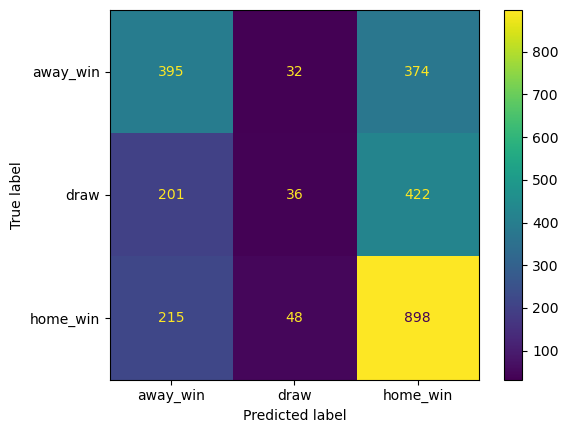

In [193]:
rf_default_cm = confusion_matrix(le.inverse_transform(y_all_test_encd), 
                                 le.inverse_transform(rf_default_pred))
cm_display = ConfusionMatrixDisplay(confusion_matrix = rf_default_cm, 
                                    display_labels = le.inverse_transform(rf_default.classes_))
cm_display.plot();    

In [194]:
print(classification_report(le.inverse_transform(y_all_test_encd), 
                            le.inverse_transform(rf_default_pred)))

              precision    recall  f1-score   support

    away_win       0.49      0.49      0.49       801
        draw       0.31      0.05      0.09       659
    home_win       0.53      0.77      0.63      1161

    accuracy                           0.51      2621
   macro avg       0.44      0.44      0.40      2621
weighted avg       0.46      0.51      0.45      2621



### Default LightGBM confusion matrix

In [195]:
lgbm_default = lgb.LGBMClassifier()
lgbm_default.fit(X_all_train_std, y_all_train_encd)
lgbm_default_pred = lgbm_default.predict(X_all_test_std)

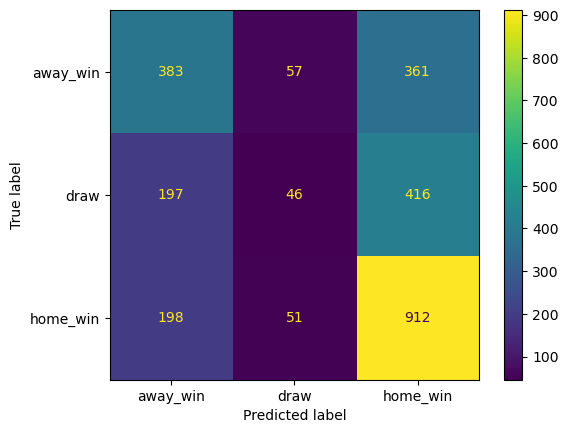

In [196]:
lgbm_default_cm = confusion_matrix(le.inverse_transform(y_all_test_encd), 
                                   le.inverse_transform(lgbm_default_pred))
cm_display = ConfusionMatrixDisplay(confusion_matrix = lgbm_default_cm, 
                                    display_labels = le.inverse_transform(lgbm_default.classes_))
cm_display.plot();    

In [197]:
print(classification_report(le.inverse_transform(y_all_test_encd), 
                            le.inverse_transform(lgbm_default_pred)))

              precision    recall  f1-score   support

    away_win       0.49      0.48      0.49       801
        draw       0.30      0.07      0.11       659
    home_win       0.54      0.79      0.64      1161

    accuracy                           0.51      2621
   macro avg       0.44      0.44      0.41      2621
weighted avg       0.46      0.51      0.46      2621



# 4. Hyperparameter tuning

## 4.1. Random forest

- Candidate hyperparameters are as follow:
    - n_estimators: 100, 300, 500, 1000
    - learning_rate: 1e-8 ~ 1 
    - max_depth: 3 ~ 20 
    - max_features: auto, sqrt, log2
    - min_samples_leaf: 1 ~ 10
    - min_samples_split: 2 ~ 10

In [147]:
def rf_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 300, 500, 1000]),
        "max_depth": trial.suggest_int("max_depth", 3, 20, step = 2),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
    }
    
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = RandomForestClassifier(**param_grid, n_jobs = -1)
        model.fit(X_train, y_train)
          
        pred = model.predict(X_test)
        cv_scores[idx] = np.mean(pred == y_test)

    return np.mean(cv_scores)

In [ ]:
rf_study = optuna.create_study(direction = "maximize", study_name = "RandomForest Classifier")
func = lambda trial: rf_objective(trial, X_all_train_std, y_all_train_encd)
rf_study.optimize(func, n_trials = 20)

- Best parameters are as follow:

In [149]:
rf_study.best_params

{'n_estimators': 300,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'min_samples_split': 4}

- Let's check the test accuracy with the best hyperparameters set.

In [200]:
rf_best = RandomForestClassifier(**rf_study.best_params)
rf_best.fit(X_all_train_std, y_all_train_encd)
rf_best_pred = rf_best.predict(X_all_test_std)
rf_best_accuracy = np.mean(rf_best_pred == y_all_test_encd)

In [201]:
print("Accuracy before tuning the hyperparameters: ", result_accuracy[result_accuracy.model_name == "Random Forest"]["All Variables"].values[0])
print("Accuracy after tuning the hyperparameters: ", rf_best_accuracy * 100)

Accuracy before tuning the hyperparameters:  52.003
Accuracy after tuning the hyperparameters:  52.04120564669973


- Let's check the confusion matrix of the tuned random forest model.

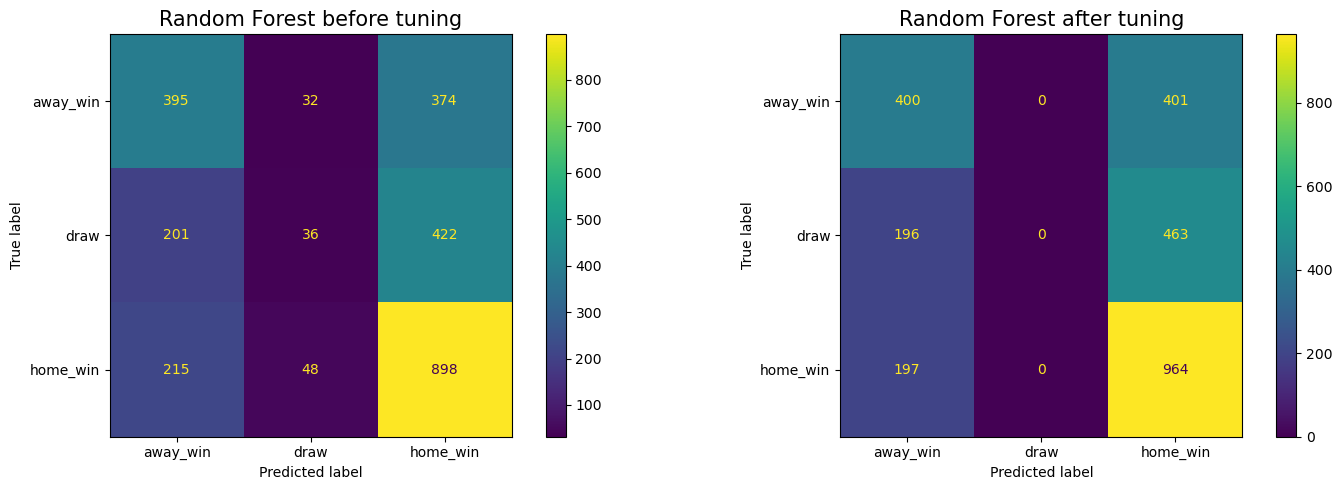

In [204]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

# confusion matrix for the random forest with default hyperparameters

rf_default_display = ConfusionMatrixDisplay(confusion_matrix = rf_default_cm, 
                                            display_labels = le.inverse_transform(rf_default.classes_))

# confusion matrix for the random forest with the best hyperparameters

rf_tuned_cm = confusion_matrix(le.inverse_transform(y_all_test_encd), 
                               le.inverse_transform(rf_best_pred))
rf_best_display = ConfusionMatrixDisplay(confusion_matrix = rf_tuned_cm, 
                                    display_labels = le.inverse_transform(rf_best.classes_))

rf_default_display.plot(ax = axes[0])
axes[0].set_title("Random Forest before tuning", fontsize = 15)

rf_best_display.plot(ax = axes[1])
axes[1].set_title("Random Forest after tuning", fontsize = 15)

plt.tight_layout()

In [208]:
print("< Random Forest before tuning >")
print("")
print(classification_report(le.inverse_transform(y_all_test_encd), 
                            le.inverse_transform(rf_default_pred)))

print("")
print("< Random Forest after tuning >")
print("")
print(classification_report(le.inverse_transform(y_all_test_encd), 
                            le.inverse_transform(rf_best_pred)))

< Random Forest before tuning >

              precision    recall  f1-score   support

    away_win       0.49      0.49      0.49       801
        draw       0.31      0.05      0.09       659
    home_win       0.53      0.77      0.63      1161

    accuracy                           0.51      2621
   macro avg       0.44      0.44      0.40      2621
weighted avg       0.46      0.51      0.45      2621


< Random Forest after tuning >

              precision    recall  f1-score   support

    away_win       0.50      0.50      0.50       801
        draw       0.00      0.00      0.00       659
    home_win       0.53      0.83      0.65      1161

    accuracy                           0.52      2621
   macro avg       0.34      0.44      0.38      2621
weighted avg       0.39      0.52      0.44      2621



- Results for away_win and home_win have improved, but the model is struggling to predict the draw.

## 4.2. LightGBM	

- Candidate hyperparameters are as follow:
    - learning_rate: 0.01 ~ 0.3 
    - num_leaves: 20 ~ 3000 with step = 20
    - max_depth: 3 ~ 12 
    - min_data_in_leaf: 200 ~ 10000 with step = 100
    - max_bing: 200 ~ 300
    - lambda_l1: 0 ~ 100 with step = 5
    - lambda_l2: 0 ~ 100 with step = 5
    - min_gain_to_split: 0 ~ 15
    - bagging_fraction: 0.2 ~ 0.95 with step = 0.1
    - feature_fraction: 0.2 ~ 0.95 with step = 0.1

In [184]:
def lgbm_objective(trial, X, y):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step = 20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step = 100),
        "max_bin": trial.suggest_int("max_bin", 200, 300),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step = 5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step = 5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.95, step = 0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.95, step = 0.1
        ),
        "silent": 1,
        "verbose": -1
    }
    
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    cv_scores = np.empty(5)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMClassifier(objective = "multiclass", num_class = 3, **param_grid, n_jobs = -1)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            #eval_metric = accuracy_score,
            early_stopping_rounds = 100,
            # callbacks=[
            #     LightGBMPruningCallback(trial, accuracy_score)
            # ],  # Add a pruning callback
            verbose = -1
        )
        preds = model.predict(X_test)
        accuracy = np.mean(y_test == preds)
        cv_scores[idx] = accuracy

    return np.mean(cv_scores)

In [ ]:
lgbm_study = optuna.create_study(direction = "maximize", study_name = "LightGBM Classifier")
func = lambda trial: lgbm_objective(trial, X_all_train_std, y_all_train_encd)
lgbm_study.optimize(func, n_trials = 100)

- Best parameters are as follow:

In [198]:
lgbm_study.best_params

{'n_estimators': 10000,
 'learning_rate': 0.29341244351241397,
 'num_leaves': 1560,
 'max_depth': 12,
 'min_data_in_leaf': 1800,
 'max_bin': 205,
 'lambda_l1': 20,
 'lambda_l2': 0,
 'min_gain_to_split': 12.558014144849205,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'feature_fraction': 0.30000000000000004}

In [ ]:
lgb_best = lgb.LGBMClassifier(**lgbm_study.best_params, n_jobs = -1)
lgb_best.fit(X_all_train_std, y_all_train_encd)
lgb_best_pred = lgb_best.predict(X_all_test_std)
lgbm_best_accuracy = np.mean(lgb_best_pred == y_all_test_encd)

In [210]:
print("Accuracy before tuning the hyperparameters: ", result_accuracy[result_accuracy.model_name == "LightGBM"]["All Variables"].values[0])
print("Accuracy after tuning the hyperparameters: ", lgbm_best_accuracy * 100)

Accuracy before tuning the hyperparameters:  51.164
Accuracy after tuning the hyperparameters:  52.003052270125906


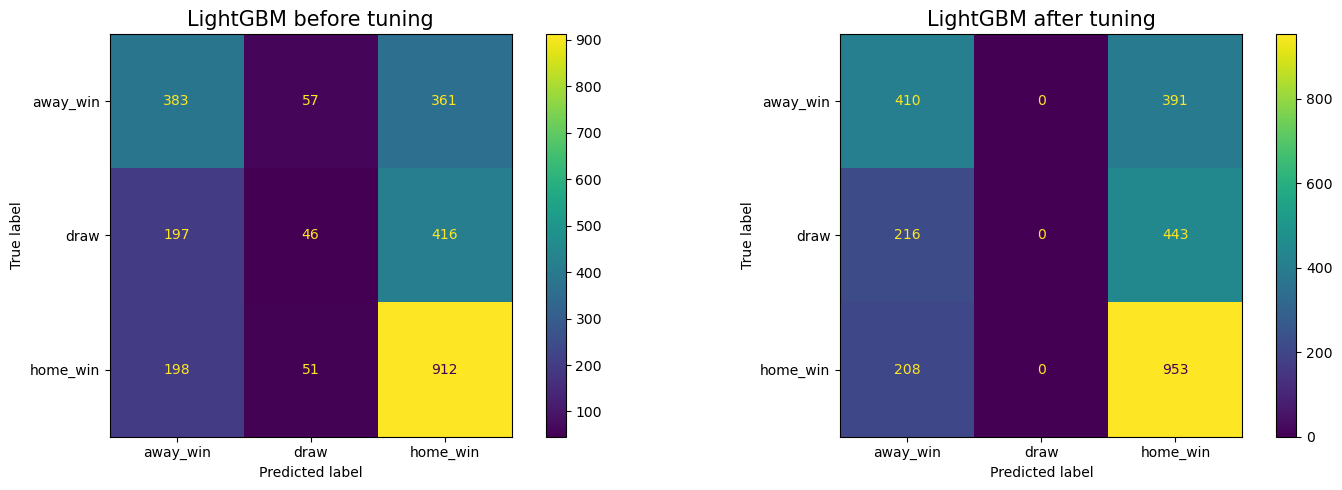

In [211]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))

# confusion matrix for the lgbm with default hyperparameters

lgbm_default_display = ConfusionMatrixDisplay(confusion_matrix = lgbm_default_cm, 
                                              display_labels = le.inverse_transform(lgbm_default.classes_))

# confusion matrix for the lgbm with the best hyperparameters

lgbm_tuned_cm = confusion_matrix(le.inverse_transform(y_all_test_encd), 
                                 le.inverse_transform(lgb_best_pred))
lgbm_best_display = ConfusionMatrixDisplay(confusion_matrix = lgbm_tuned_cm, 
                                           display_labels = le.inverse_transform(lgb_best.classes_))

lgbm_default_display.plot(ax = axes[0])
axes[0].set_title("LightGBM before tuning", fontsize = 15)

lgbm_best_display.plot(ax = axes[1])
axes[1].set_title("LightGBM after tuning", fontsize = 15)

plt.tight_layout()

In [213]:
print("< LightGBM before tuning >")
print("")
print(classification_report(le.inverse_transform(y_all_test_encd), 
                            le.inverse_transform(lgbm_default_pred)))

print("")
print("< LightGBM after tuning >")
print("")
print(classification_report(le.inverse_transform(y_all_test_encd), 
                            le.inverse_transform(lgb_best_pred)))

< LightGBM before tuning >

              precision    recall  f1-score   support

    away_win       0.49      0.48      0.49       801
        draw       0.30      0.07      0.11       659
    home_win       0.54      0.79      0.64      1161

    accuracy                           0.51      2621
   macro avg       0.44      0.44      0.41      2621
weighted avg       0.46      0.51      0.46      2621


< LightGBM after tuning >

              precision    recall  f1-score   support

    away_win       0.49      0.51      0.50       801
        draw       0.00      0.00      0.00       659
    home_win       0.53      0.82      0.65      1161

    accuracy                           0.52      2621
   macro avg       0.34      0.44      0.38      2621
weighted avg       0.39      0.52      0.44      2621



- Results for away_win and home_win have improved, but the LightGBM is also struggling to predict the draw.

# 5. Feature importance

- Let's check the feature importance from the tuned random forest model based on feature permutation.

In [50]:
rf_best_params = {
    'n_estimators': 300,
    'max_depth': 5,
    'max_features': 'sqrt',
    'min_samples_leaf': 7,
    'min_samples_split': 4
}

In [51]:
rf_best = RandomForestClassifier(**rf_best_params)
rf_best.fit(X_all_train_std, y_all_train_encd)
rf_best_pred = rf_best.predict(X_all_test_std)
rf_best_accuracy = np.mean(rf_best_pred == y_all_test_encd)

In [55]:
result = permutation_importance(
    rf_best, X_all_test_std, y_all_test_encd, n_repeats=10, random_state=42, n_jobs=-1
)

In [56]:
rf_feature_imp_permutation =  pd.DataFrame(sorted(zip(result.importances_mean, col_names)), columns=['Value','Feature'])

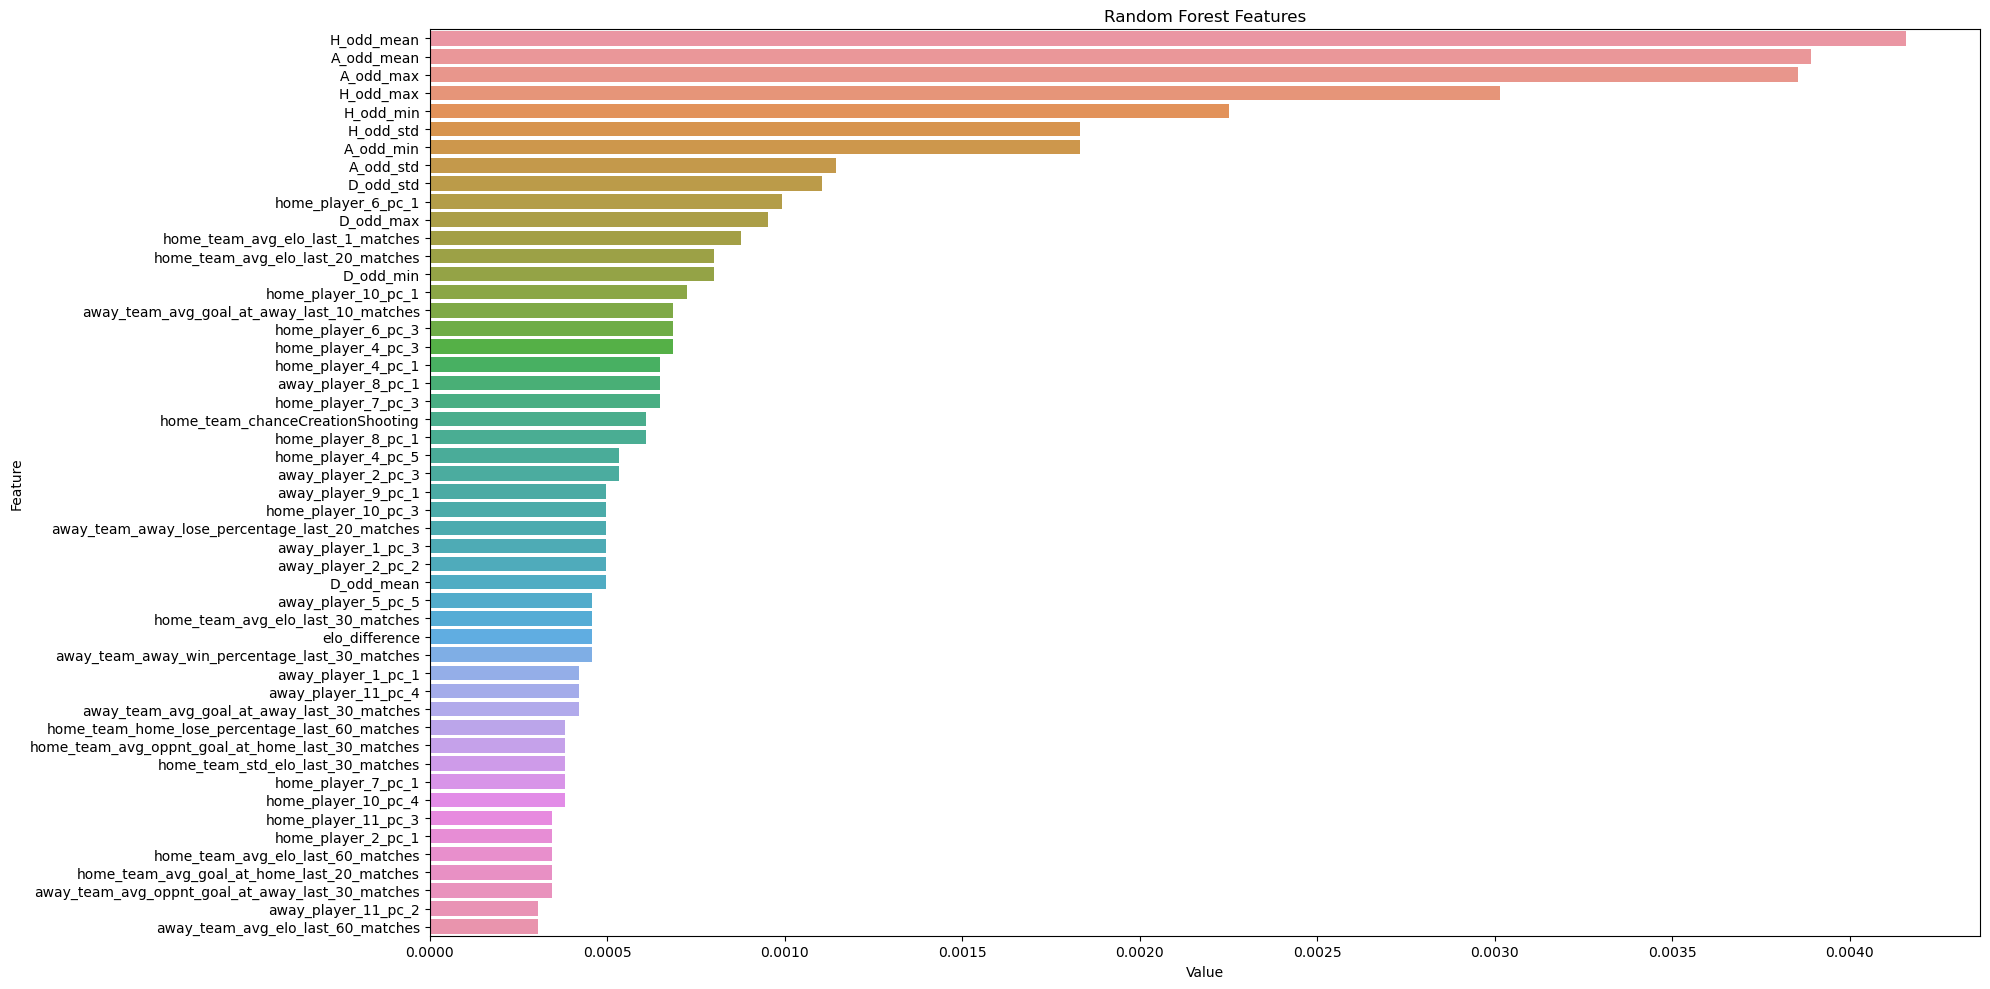

In [57]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data = rf_feature_imp_permutation.sort_values("Value", ascending = False).head(50))
plt.title('Random Forest Features')
plt.tight_layout()
plt.show()

- Above plot shows top 50 most important features for predicting the match results.

- Let's compare the distribution of the feature importance between different variable sets.
    - variable set 1: player attributes PC features
    - Variable set 2: betting information features
    - variable set 3: team attributes features
    - variable set 4: goal and win percentage rolling features
    - variable set 5: each team's Elo rating

In [67]:
player_attr_pc_vars = df_match_player_attr_pcs.columns
bet_stat_vars = df_match_betting_stat.columns
team_attr_vars = df_match_team_num_attr.columns
team_rolling_vars = df_team_win_goal_rolling_features.columns
elo_vars = df_match_elo.columns


In [77]:
rf_feature_imp_permutation.loc[rf_feature_imp_permutation.Feature.isin(player_attr_pc_vars), "feature_set"] = f"Player attribute PC variables (#: {len(player_attr_pc_vars) - 1})"
rf_feature_imp_permutation.loc[rf_feature_imp_permutation.Feature.isin(bet_stat_vars), "feature_set"] = f"Betting odds statistics variables (#: {len(bet_stat_vars) - 1})"
rf_feature_imp_permutation.loc[rf_feature_imp_permutation.Feature.isin(team_attr_vars), "feature_set"] = f"Team attribute variables (#: {len(team_attr_vars) - 1})"
rf_feature_imp_permutation.loc[rf_feature_imp_permutation.Feature.isin(team_rolling_vars), "feature_set"] = f"Team's recent average goal and win percentage variables (#: {len(team_rolling_vars) - 1})"
rf_feature_imp_permutation.loc[rf_feature_imp_permutation.Feature.isin(elo_vars), "feature_set"] = f"Team's recent Elo variables (#: {len(elo_vars) - 1})"


Text(0.5, 1.0, 'Feature importance distribution from different feature sets')

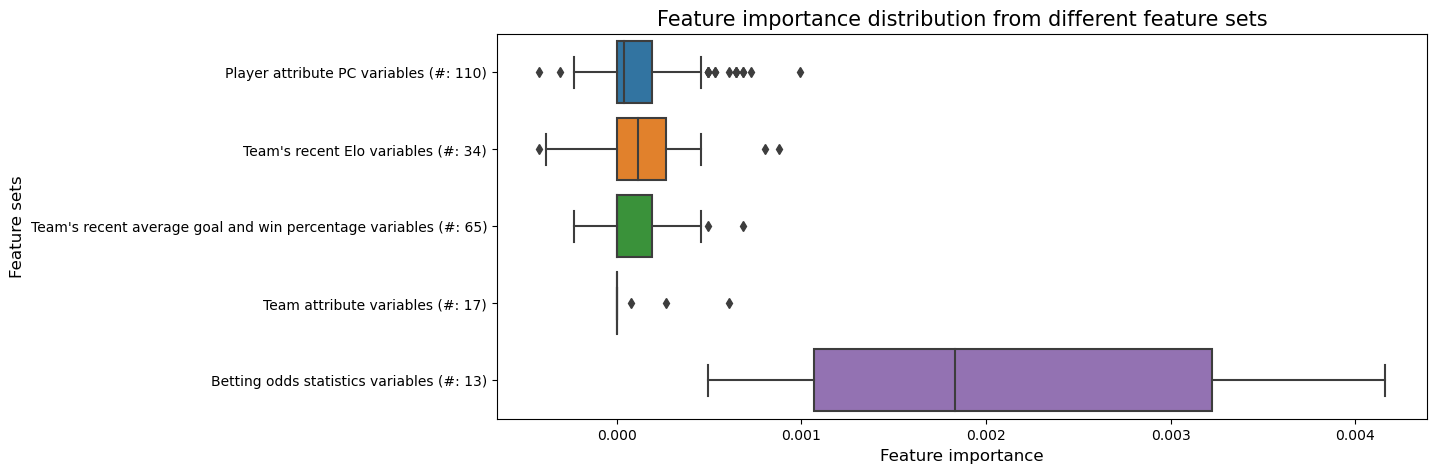

In [78]:
plt.figure(figsize = (12, 5))
sns.boxplot(data = rf_feature_imp_permutation, x = "Value", y = "feature_set")
plt.xlabel("Feature importance", fontsize = 12)
plt.ylabel("Feature sets", fontsize = 12)
plt.title("Feature importance distribution from different feature sets", fontsize = 15)

- The betting odds statistics variables shows the highest importance among different feature sets.
- Team attribute variables have the lowest feature importance.
- The remaining three variable sets show similar importance.

## 5.1. Betting odds statistics variables

- Betting odds statistics can be subdivided into:
    - home win, away win, and draw
    - mean, max, min, std

In [93]:
betting_importance = rf_feature_imp_permutation[rf_feature_imp_permutation.feature_set == "Betting odds statistics variables (#: 13)"]
betting_importance["home_away"] = betting_importance.Feature.str.split("_").str[0]
betting_importance["statistics"] = betting_importance.Feature.str.split("_").str[2]


In [95]:
betting_importance.sort_values("Value", ascending = False)

,Value,Feature,feature_set,home_away,statistics
234,0.004159,H_odd_mean,Betting odds statistics variables (#: 13),H,mean
233,0.003892,A_odd_mean,Betting odds statistics variables (#: 13),A,mean
232,0.003853,A_odd_max,Betting odds statistics variables (#: 13),A,max
231,0.003014,H_odd_max,Betting odds statistics variables (#: 13),H,max
230,0.002251,H_odd_min,Betting odds statistics variables (#: 13),H,min
229,0.001831,H_odd_std,Betting odds statistics variables (#: 13),H,std
228,0.001831,A_odd_min,Betting odds statistics variables (#: 13),A,min
227,0.001145,A_odd_std,Betting odds statistics variables (#: 13),A,std
226,0.001106,D_odd_std,Betting odds statistics variables (#: 13),D,std
224,0.000954,D_odd_max,Betting odds statistics variables (#: 13),D,max


- The importance of variables for home and away were high, and the importance of variables for draw were low.
- The importance of variables related to mean and max were high.

## 5.2. Team's recent Elo variables

- Elo rating related variables can be subdivided into:
    - home team, away team
    - average, std
    - recent 1, 3, 5, 10, 20, 30, 60, 90 matches

In [98]:
elo_importance = rf_feature_imp_permutation[rf_feature_imp_permutation.feature_set == "Team's recent Elo variables (#: 34)"]


In [107]:
elo_importance["home_away"] = elo_importance.Feature.str.split("_").str[0]
elo_importance["statistics"] = elo_importance.Feature.str.split("_").str[2]
elo_importance["matches"] = elo_importance.Feature.str.split("_").str[5]

In [110]:
elo_importance.sort_values("Value", ascending = False)

,Value,Feature,feature_set,home_away,statistics,matches
223,0.000878,home_team_avg_elo_last_1_matches,Team's recent Elo variables (#: 34),home,avg,1
222,0.000801,home_team_avg_elo_last_20_matches,Team's recent Elo variables (#: 34),home,avg,20
202,0.000458,home_team_avg_elo_last_30_matches,Team's recent Elo variables (#: 34),home,avg,30
201,0.000458,elo_difference,Team's recent Elo variables (#: 34),elo,NaN,NaN
194,0.000382,home_team_std_elo_last_30_matches,Team's recent Elo variables (#: 34),home,std,30
189,0.000343,home_team_avg_elo_last_60_matches,Team's recent Elo variables (#: 34),home,avg,60
185,0.000305,away_team_avg_elo_last_60_matches,Team's recent Elo variables (#: 34),away,avg,60
181,0.000267,home_team_std_elo_last_90_matches,Team's recent Elo variables (#: 34),home,std,90
173,0.000267,away_team_avg_elo_last_10_matches,Team's recent Elo variables (#: 34),away,avg,10
172,0.000229,home_team_avg_elo_last_5_matches,Team's recent Elo variables (#: 34),home,avg,5


In [113]:
elo_importance.groupby("home_away").Value.mean()

home_away
away    0.000057
elo     0.000458
home    0.000210
Name: Value, dtype: float64